In [1]:
# Reference : https://github.com/graykode/nlp-tutorial
import tensorflow as tf
import numpy as np

## Input Data
- S: Symbol that shows starting of decoding input
- E: Symbol that shows starting of decoding output
- P: Symbol that will fill in blank sequence if current batch data size is short than time steps

In [2]:
animals = [
    ('dog', '강아지'), 
    ('cat', '고양이'),
    ('hamster', '햄스터'),
    ('rabbit', '토끼'),
    ('fox', '여우'),
    ('lion', '사자'),
    ('tiger', '호랑이'),
    ('leopard', '표범'),
    ('zebar','얼룩말'),
    ('horse','말'),
    ('giraffe','기린'),
    ('hippotamus','하마'),
    ('crocodile','악어'),
    ('alligator','악어'),
    ('kangaroo','캥거루'),
    ('koala','코알라'),
    ('elephant', '코끼리'),
    ('snake','뱀'),
    ('deer','사슴'),
    ('reindeer', '순록'),
    ('panda','팬더'),
    ('bear','곰'),
    ('racoon','너구리'),
    ('otter','수달'),
    ('cheetah', '치타'),
    ('pig','돼지'),
]

states = [
    ('cute', '귀엽다'),
    ('big', '크다'),
    ('small', '작다'),
    ('fast','빠르다'),
    ('slow','느리다'),
    ('good','좋다'),
    ('bad','나쁘다'),
    ('loud','시끄럽다'),
    ('quiet','조용하다'),
    ('stupid','멍청하다'),
    ('heavy','무겁다'),
    ('light','가볍다'),
    ('weak','약하다'),
    ('strong','강하다'),
    ('young','젋다'),
    ('old','늙었다'),
    ('long','길다'),
    ('short', '짧다'),
    ('generous','관대하다'),
    ('mean','인색하다'),
    ('beautiful','아름답다'),
    ('ugly','못생겼다'),
    ('happy','행복하다'),
    ('sad','슬프다'),
] 

sentences = []
for animal in animals:
    for state in states:
        encoder_input = 'The {} is {} P'.format(animal[0], state[0])
        decoder_input = 'S 그 {} 는 {}'.format(animal[1], state[1])
        decoder_output = '그 {} 는 {} E'.format(animal[1], state[1])
        
        sentences.append([encoder_input, decoder_input,decoder_output])
        
        encoder_input = 'The {} are {} P'.format(animal[0], state[0])
        decoder_input = 'S 그 {} 들은 {}'.format(animal[1], state[1])
        decoder_output = '그 {} 들은 {} E'.format(animal[1], state[1])
        
        sentences.append([encoder_input, decoder_input,decoder_output])
        
        encoder_input = 'That {} are {} P'.format(animal[0], state[0])
        decoder_input = 'S 저 {} 들은 {}'.format(animal[1], state[1])
        decoder_output = '저 {} 들은 {} E'.format(animal[1], state[1])
        
        sentences.append([encoder_input, decoder_input,decoder_output])
        
word_list = " ".join(np.array(sentences).flatten()).split() + ['P']
word_list = list(set(word_list))
word_dict = {w: i for i, w in enumerate(word_list)}
number_dict = {i: w for i, w in enumerate(word_list)}
n_class = len(word_dict)  # vocab list

# Parameter
n_step = 5  # maxium number of words in one sentence(=number of time steps)
n_hidden = 128

def make_batch(sentences):
    input_batch, output_batch, target_batch = [], [], []
    
    np.random.seed(9)
    shuffle_indices = np.random.permutation(np.arange(len(sentences)))
    
    for index in shuffle_indices:
        sentence=sentences[index]
        
        input_batch.append(np.eye(n_class)[[word_dict[n] for n in sentence[0].split()]])
        output_batch.append(np.eye(n_class)[[word_dict[n] for n in sentence[1].split()]])
        target_batch.append([word_dict[n] for n in sentence[2].split()])
    
    return input_batch, output_batch, target_batch

## Model

In [3]:
enc_inputs = tf.placeholder(tf.float32, [None, n_step, n_class])  # [batch_size, n_step, n_class]
dec_inputs = tf.placeholder(tf.float32, [None, n_step, n_class])  # [batch_size, n_step, n_class]
targets = tf.placeholder(tf.int64, [None, n_step])  # [batch_size, n_step], not one-hot

# Linear for attention
attn = tf.Variable(tf.random_normal([n_hidden, n_hidden]))
out = tf.Variable(tf.random_normal([n_hidden * 2, n_class]))

# dec_output = [batch_size, 1, n_hidden(=128)] 
# enc_output: [batch_size, n_hidden]
def get_att_score(dec_output, enc_output): 
    score = tf.matmul(enc_output, attn) # score: [batch_size, n_hidden]
    dec_output = tf.squeeze(dec_output, 1) # dec_output: [batch_size, n_hidden]
    return tf.reduce_sum(tf.multiply(score, dec_output), 1) # inner product makce scalar value

def get_att_weights(dec_output, enc_outputs): 
    attn_scores = [] # list of attention scalar : [n_step]
    enc_outputs = tf.transpose(enc_outputs, [1, 0, 2]) # enc_outputs : [batch_size, n_step, n_hidden] -> [n_step, batch_size, n_hidden]
    for i in range(n_step):
        att_score = get_att_score(dec_output, enc_outputs[i]) # att_score: [batch_size]
        attn_scores.append(att_score) 
    
    # Normalize scores to weights in range 0 to 1
    attn_scores = tf.transpose(attn_scores, [1, 0]) # [n_step, batch_size] -> [batch_size, n_step]
    return tf.nn.softmax(attn_scores) 

model = []
Attention = []
with tf.variable_scope('encode'):
    enc_cell = tf.nn.rnn_cell.BasicRNNCell(n_hidden)
    enc_cell = tf.nn.rnn_cell.DropoutWrapper(enc_cell, output_keep_prob = 0.5)

    enc_outputs, enc_hidden = tf.nn.dynamic_rnn(enc_cell, enc_inputs, dtype=tf.float32)
    # enc_outputs: [batch_size, n_step(=decoder_step), n_hidden(=128)]
    # enc_hidden: [batch_size, n_hidden(=128)]

with tf.variable_scope('decode'):
    dec_cell = tf.nn.rnn_cell.BasicRNNCell(n_hidden)
    dec_cell = tf.nn.rnn_cell.DropoutWrapper(dec_cell, output_keep_prob=0.5)
    
    inputs = tf.transpose(dec_inputs, [1, 0, 2]) # [batch_size, n_step, n_class] -> [n_step, batch_size, n_class]
    hidden = enc_hidden
    for i in range(n_step):
        dec_output, hidden = tf.nn.dynamic_rnn(dec_cell, 
                                               tf.expand_dims(inputs[i], 1), # [batch_size, 1, n_class]                                               
                                               initial_state=hidden,
                                               dtype=tf.float32)
        # dec_output: [batch_size, 1, n_hidden(=128)]
        # hidden: [batch_size, n_hidden(=128)]
        
        attn_weights = get_att_weights(dec_output, enc_outputs) # attn_weights: [batch_size, n_step]
        Attention.append(attn_weights) 
        
        attn_weights = tf.reshape(attn_weights, [-1, 1, n_step]) # [batch_size, 1, n_step]
        # [batch_size, 1, n_step] x [batch_size, n_step, n_hidden] = [batch_size, 1, n_hidden]
        context = tf.matmul(attn_weights, enc_outputs)
        context = tf.squeeze(context, 1) # [batch_size, 1, n_hidden] -> [batch_size, n_hidden]
        
        dec_output = tf.squeeze(dec_output, 1) # [batch_size, 1, n_hidden] -> [batch_size, n_hidden]      
        concated = tf.concat((dec_output, context), 1) # [batch_size, n_hidden] -> [batch_size, 2*n_hidden]
        model.append(tf.matmul(concated, out)) # [batch_size, n_class]
    
    
    # Attention[0]: [batch_size, n_step]
    # to show attention matrix
    Attention = tf.transpose(Attention, [1, 0, 2]) # [n_step_decoder, batch_size, n_step_encoder)] -> [batch_size, n_step_decoder, n_step_encoder]
    
    # model: [n_step, batch_size, n_class] -> [batch_size, n_step, n_class]
    model = tf.transpose(model, [1, 0, 2]) 
    prediction = tf.argmax(model, 2)
    cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=model, labels=targets))
    optimizer = tf.train.AdamOptimizer(0.001).minimize(cost)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


## Train

In [4]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

for epoch in range(2000):
    input_batch, output_batch, target_batch = make_batch(sentences)
    _, loss, attention = sess.run([optimizer, cost, Attention], feed_dict={
        enc_inputs: input_batch,
        dec_inputs: output_batch,
        targets: target_batch,
    })

    if (epoch + 1) % 200 == 0:
        print('Epoch :', '%04d' % (epoch + 1), 'cost = ', '{:.10f}'.format(loss))

Epoch : 0200 cost =  0.0165938176
Epoch : 0400 cost =  0.0063314498
Epoch : 0600 cost =  0.0031823025
Epoch : 0800 cost =  0.0016522098
Epoch : 1000 cost =  0.0009642806
Epoch : 1200 cost =  0.0008184210
Epoch : 1400 cost =  0.0006487144
Epoch : 1600 cost =  0.0005815891
Epoch : 1800 cost =  0.0004293810
Epoch : 2000 cost =  0.0004177091


['The', 'dog', 'is', 'cute', 'P'] -> ['그', '사슴', '는', '작다', 'E']


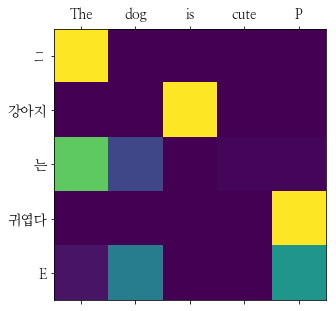

['The', 'dog', 'are', 'cute', 'P'] -> ['저', '돼지', '들은', '관대하다', 'E']


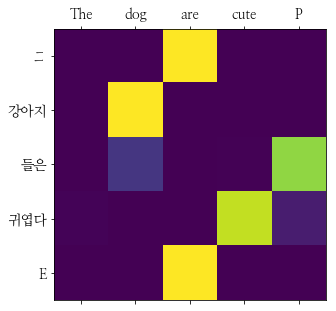

['That', 'dog', 'are', 'cute', 'P'] -> ['저', '강아지', '들은', '귀엽다', 'E']


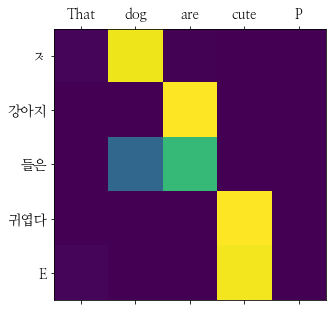

['The', 'dog', 'is', 'big', 'P'] -> ['저', '팬더', '들은', '관대하다', 'E']


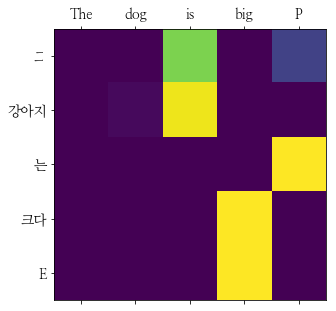

['The', 'dog', 'are', 'big', 'P'] -> ['저', '치타', '들은', '좋다', 'E']


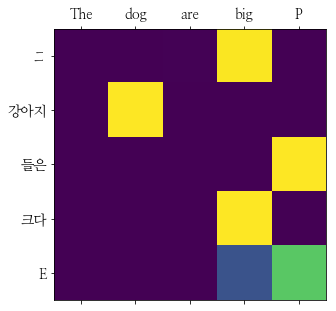

['That', 'dog', 'are', 'big', 'P'] -> ['저', '캥거루', '들은', '길다', 'E']


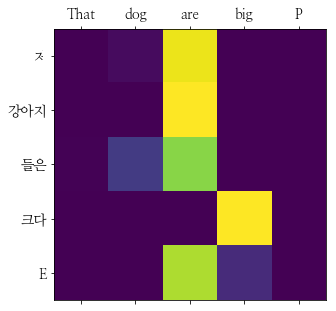

['The', 'dog', 'is', 'small', 'P'] -> ['그', '캥거루', '들은', '슬프다', 'E']


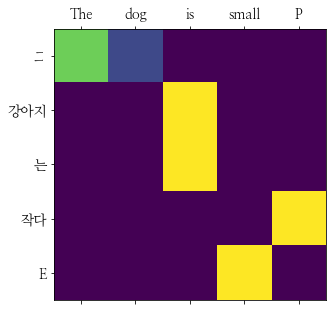

['The', 'dog', 'are', 'small', 'P'] -> ['저', '고양이', '들은', '크다', 'E']


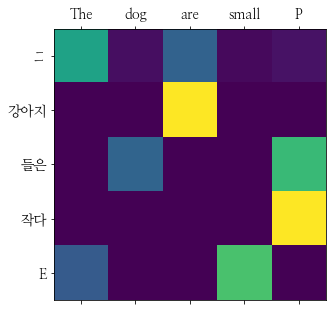

['That', 'dog', 'are', 'small', 'P'] -> ['그', '고양이', '는', '약하다', 'E']


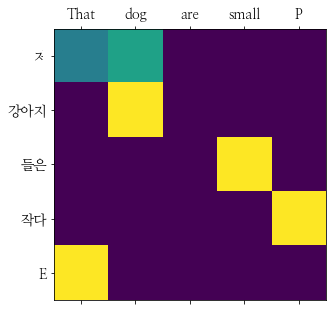

['The', 'dog', 'is', 'fast', 'P'] -> ['그', '고양이', '는', '아름답다', 'E']


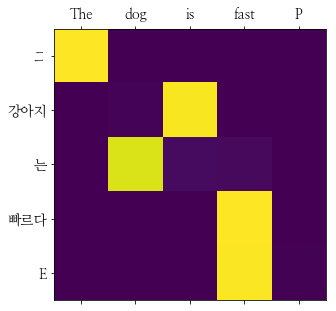

In [6]:
# Show Attention
import matplotlib.pyplot as plt

# Set Korean Font
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="/usr/share/fonts/truetype/nanum/NanumMyeongjo.ttf").get_name()
rc('font', family=font_name)

predict_batch = [np.eye(n_class)[[word_dict[n] for n in 'P P P P P'.split()]]] * len(sentences)
results = sess.run(prediction, feed_dict = {enc_inputs: input_batch, dec_inputs: output_batch})

for i in range(len(sentences[:10])):
    print(sentences[i][0].split(), '->', [number_dict[n] for n in results[i]])

    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention[i], cmap='viridis')
    ax.set_xticklabels([''] + sentences[i][0].split(), fontdict={'fontsize': 14})
    ax.set_yticklabels(['']+ sentences[i][2].split(), fontdict={'fontsize': 14})
    plt.show()